# **PROYECTO FINAL CIENCIA DE DATOS CON PYTHON**

UNIVERSIDAD GALILEO </br>
INSTITUTO DE INVESTIGACIÓN DE OPERACIONES </br>
CIENCIA DE DATOS EN PYTHON </br>

<br>
Integrantes:

- Karina Díaz
- Antonio Guoron
- Erick Fuentes



La grabación del video del proyecto está en el siguiente link [Video Presentacion](https://drive.google.com/file/d/1q7fd8S1b_dxwqnRPvCi_UlKkY2YJmPMt/view?usp=sharing).

## **SCOPE**



El propósito de este proyecto fue desarrollar una base de datos para cumplir los requerimientos de almacenamiento y análisis de datos de las órdenes de un supermercado a través de consultas de información, utilizando Python. 

Para ello, se realizó un análisis de la información brindada por el supermercado, que cuenta con varias tiendas desplegadas en varios estados. Cada tienda tiene varios departamentos tales como: abarrotes, comida congelada, lácteos, carnes, verduras y vegetales, panadería, floristería y productos de salud/belleza y también cada tienda tiene muchos productos individuales que se llaman SKUs en cada uno de sus anaqueles.

Los datos que se utilizan para el supermercado se recolectan por cajas registradoras cuando los clientes realizan cada una de sus compras con un sistema POS donde se lleva el control de cada producto que estos clientes compran, la gerencia también se preocupa por la logística de ordenar, colocar y vender productos mientras se maximiza la ganancias, por lo cual se toman varias decisiones para ver que tipos de estrategias de ventas utilizar para llamar la atención de los clientes.

Para realizar el análisis de datos, se elaboró un script de Python, a través de:
- Creación de instancia MySQL y script para la creación de tablas
- Lectura de archivos csv desde buckets de AWS
- Generación de dataframes para tablas de dimensiones
- Carga de datos de las tablas de dimensiones al datawarehouse
- Carga de datos a la tabla de hechos
- Realización de consultas de información de acuerdo a las preguntas del negocio


## **EXPLORACION**

Para la exploracion de datos se realizaron los siguiente pasos: 

**SECCION 1 - AMBIENTE: CREACION DE INSTANCIA MYSQL Y SCRIPT PARA CREACION DE TABLAS**
<br>
Carga de archivos de configuración
Creación de instancia de AWS
Validación de instancias
Definición de nombre de la instancia
Creación de servicio
Obtención de la URL del host
Conección a la base de datos y creación de tablas en el modelo estrella

**SECCION 2 - LECTURA DE ARCHIVOS CSV DESDE S3**
<br>
Carga de 4 archivos .csv como buckets de AWS
Agrupación de los 4 archivos en un solo dataframe
Carga derdatos para poblar la inforamción de fechas

**SECCION 3 - GENERAR DATAFRAMES PARA TABLAS DE DIMENSIONES (DIM TABLES)**
<br>
Definición de dimensión clientes (CUSTOMER_DIM)
Definición de dimensión ubicación (LOCATION_DIM)
Definición de dimensión Producto (PRODUCT_DIM)
Definición de dimensión Región (REGION_DIM)
Definición de método de envío (SHIPMODE_DIM)
Definición de dimensión fecha (DATE_DIM)

**SECCION 4 - CARGA DE DATOS DIM TABLES A DW**
<br>
Carga de datos de las tablas de dimensiones (DIM TABLES)

**SECCION 5 - CARGA DE DATOS A FACT TABLE**
<br>
Extracción de las dimensiones
Limpieza y unión de datos (limpieza y merge)
Inserción de datos


## **MODELO DE DATOS**

Para construir el DataWarehouse se utilizó el modelo en estrella, y el diagrama se presenta a continuación:

<img src="modelorelacional.png">

## **PROCESAMIENTO**

#### LOS DATOS FUERON TOMADOS DE ARCHIVOS CSV QUE ESTAN EN UN BUCKET DE S3 AWS. ESTOS ARCHIVOS CONTIENEN LA INFORMACION DE VENTAS DE UNA TIENDA.

## SECCION 1 - AMBIENTE: CREACION DE INSTANCIA MYSQL Y SCRIPT PARA CREACION DE TABLAS

In [1]:
import pandas as pd
import numpy as np
from faker import Faker
import random
import datetime
import boto3
import psycopg2
import configparser
from io import StringIO

### CARGAMOS ARCHIVOS DE CONFIGURACIÓN

In [2]:
config = configparser.ConfigParser()
config.read('configuracion.cfg')

['configuracion.cfg']

### CREAMOS INSTANCIA DE AWS

In [3]:
aws_conn = boto3.client('rds', aws_access_key_id=config.get('IAM', 'ACCESS_KEY'),
                    aws_secret_access_key=config.get('IAM', 'SECRET_ACCESS_KEY'),
                    region_name='us-east-1')
print(aws_conn)

### VALIDAMOS INSTANCIAS

In [4]:
rdsInstanceIds = []

response = aws_conn.describe_db_instances()
for resp in response['DBInstances']:
    rdsInstanceIds.append(resp['DBInstanceIdentifier'])
    db_instance_status = resp['DBInstanceStatus']

print(f"DBInstanceIds {rdsInstanceIds}")

DBInstanceIds []


### NOMBRE DE LA INSTANCIA

In [5]:
rdsIdentifier = 'proyecto'

### CREAMOS SERVICIO

In [6]:
try:
    response = aws_conn.create_db_instance(
            AllocatedStorage=10,
            DBName=config.get('RDS_MYSQL', 'DB_NAME'),
            DBInstanceIdentifier=rdsIdentifier,
            DBInstanceClass="db.t3.micro",
            Engine="mysql",
            MasterUsername=config.get('RDS_MYSQL', 'DB_USER'),
            MasterUserPassword=config.get('RDS_MYSQL', 'DB_PASSWORD'),
            Port=int(config.get('RDS_MYSQL', 'DB_PORT')),
            VpcSecurityGroupIds=[config.get('VPC', 'SECURITY_GROUP')],
            PubliclyAccessible=True
        )
    print(response)
except aws_conn.exceptions.DBInstanceAlreadyExistsFault as ex:
    print("La Instancia de Base de Datos ya Existe.")

{'DBInstance': {'DBInstanceIdentifier': 'proyecto', 'DBInstanceClass': 'db.t3.micro', 'Engine': 'mysql', 'DBInstanceStatus': 'creating', 'MasterUsername': 'root', 'DBName': 'dw_proyecto', 'AllocatedStorage': 10, 'PreferredBackupWindow': '04:15-04:45', 'BackupRetentionPeriod': 1, 'DBSecurityGroups': [], 'VpcSecurityGroups': [{'VpcSecurityGroupId': 'sg-0f844de3bd7b25d9f', 'Status': 'active'}], 'DBParameterGroups': [{'DBParameterGroupName': 'default.mysql8.0', 'ParameterApplyStatus': 'in-sync'}], 'DBSubnetGroup': {'DBSubnetGroupName': 'default', 'DBSubnetGroupDescription': 'default', 'VpcId': 'vpc-01a3d918cb4f27d41', 'SubnetGroupStatus': 'Complete', 'Subnets': [{'SubnetIdentifier': 'subnet-0d63e3de577a32fee', 'SubnetAvailabilityZone': {'Name': 'us-east-1a'}, 'SubnetOutpost': {}, 'SubnetStatus': 'Active'}, {'SubnetIdentifier': 'subnet-06367c1c3ee76ec4b', 'SubnetAvailabilityZone': {'Name': 'us-east-1e'}, 'SubnetOutpost': {}, 'SubnetStatus': 'Active'}, {'SubnetIdentifier': 'subnet-00543166cf

### OBTENEMOS URL DEL HOST

In [7]:
try:
     instances = aws_conn.describe_db_instances(DBInstanceIdentifier=rdsIdentifier)
     RDS_DW_HOST = instances.get('DBInstances')[0].get('Endpoint').get('Address')
     print(RDS_DW_HOST)
except Exception as ex:
     print("La instancia de base de datos no existe o aun no se ha terminado de crear.")
     print(ex)

proyecto.ciuvpzinrrre.us-east-1.rds.amazonaws.com


### NOS CONECTAMOS A LA BD Y CREAMOS LAS TABLAS EN EL MODELO ESTRELLA

In [8]:
import create_dw_query
import mysql.connector as mysqlC

try:
    myDw = mysqlC.connect(
    host=RDS_DW_HOST, 
    user=config.get('RDS_MYSQL', 'DB_USER'),
    password=config.get('RDS_MYSQL', 'DB_PASSWORD'),
    database=config.get('RDS_MYSQL', 'DB_NAME')
    )

    mycursor = myDw.cursor()
    mycursor.execute(create_dw_query.CREATE_DW)
    mycursor.fetchall()
    print("Data Warehouse Creado Exitosamente")
except Exception as ex:
    print("ERROR: Error al crear la base de datos.")
    print(ex)

Data Warehouse Creado Exitosamente


## SECCION 2 - LECTURA DE ARCHIVOS CSV DESDE S3

In [9]:
s3 = boto3.resource(
    service_name = 's3',
    region_name = 'us-east-1',
    aws_access_key_id = config.get('IAM', 'ACCESS_KEY'),
    aws_secret_access_key = config.get('IAM', 'SECRET_ACCESS_KEY')
)

for bucket in s3.buckets.all():
    S3_BUCKET_NAME = bucket.name
    print(bucket.name)

remoteFileList = []
for objt in s3.Bucket(S3_BUCKET_NAME).objects.all():
    remoteFileList.append(objt.key)

remoteFileList

bucket-proyecto-2023


['Orders_Central.csv',
 'Orders_East.csv',
 'Orders_South.csv',
 'Orders_West.csv',
 'date_dim.csv']

In [10]:
s3 = boto3.client(
    service_name = 's3',
    region_name = 'us-east-1',
    aws_access_key_id = config.get('IAM', 'ACCESS_KEY'),
    aws_secret_access_key = config.get('IAM', 'SECRET_ACCESS_KEY')
)

## CARGAMOS LOS ARCHIVOS CSV CON LOS DATOS DE LAS VENTAS
## SON 4 ARCHIVOS, UNO POR CADA REGION

object_key = 'Orders_Central.csv'
csv_obj = s3.get_object(Bucket=S3_BUCKET_NAME, Key=object_key)
body = csv_obj['Body']
csv_string = body.read().decode('utf-8')
df_orders_central = pd.read_csv(StringIO(csv_string))

object_key = 'Orders_East.csv'
csv_obj = s3.get_object(Bucket=S3_BUCKET_NAME, Key=object_key)
body = csv_obj['Body']
csv_string = body.read().decode('utf-8')
df_orders_east = pd.read_csv(StringIO(csv_string))

object_key = 'Orders_South.csv'
csv_obj = s3.get_object(Bucket=S3_BUCKET_NAME, Key=object_key)
body = csv_obj['Body']
csv_string = body.read().decode('utf-8')
df_orders_south = pd.read_csv(StringIO(csv_string))

object_key = 'Orders_West.csv'
csv_obj = s3.get_object(Bucket=S3_BUCKET_NAME, Key=object_key)
body = csv_obj['Body']
csv_string = body.read().decode('utf-8')
df_orders_west = pd.read_csv(StringIO(csv_string))

## AGRUPAMOS LOS 4 ARCHIVOS EN UN SOLO DATAFRAME
df_orders_all = pd.concat([df_orders_central, df_orders_east, df_orders_south, df_orders_west])

In [11]:
## CARGAMOS LOS DATOS PARA POBLAR LA DIMENSION DE FECHAS

object_key = 'date_dim.csv'
csv_obj = s3.get_object(Bucket=S3_BUCKET_NAME, Key=object_key)
body = csv_obj['Body']
csv_string = body.read().decode('utf-8')

df_dates = pd.read_csv(StringIO(csv_string))

## SECCION 3 - GENERAR DATAFRAMES PARA DIM TABLES

### DIMENSION CLIENTES

In [12]:
df_customer_dim = df_orders_all[["Customer ID", "Customer Name", "Segment"]].drop_duplicates()
df_customer_dim.columns = ["CUSTOMER_ID", "CUSTOMER_NAME", "SEGMENT"]

df_customer_dim.head(5)

,CUSTOMER_ID,CUSTOMER_NAME,SEGMENT
0,HP-14815,Harold Pawlan,Home Office
2,PK-19075,Pete Kriz,Consumer
3,KB-16585,Ken Black,Corporate
5,MA-17560,Matt Abelman,Home Office
6,GH-14485,Gene Hale,Corporate


### DIMENSION LOCATION

In [13]:
df_location_dim = df_orders_all[["Country", "City", "State", "Postal Code"]].drop_duplicates()
df_location_dim.columns = ["COUNTRY", "CITY", "STATE", "POSTAL_CODE"]

# LIMPIAMOS LOS DATOS NULL
df_location_dim['POSTAL_CODE'] = df_location_dim['POSTAL_CODE'].fillna(-1)
df_location_dim['POSTAL_CODE'] = df_location_dim['POSTAL_CODE'].astype("Int64")

df_location_dim.head(5)

,COUNTRY,CITY,STATE,POSTAL_CODE
0,United States,Fort Worth,Texas,76106
2,United States,Madison,Wisconsin,53711
3,United States,Fremont,Nebraska,68025
5,United States,Houston,Texas,77095
6,United States,Richardson,Texas,75080


### DIMENSION PRODUCT_DIM

In [14]:
df = df_orders_all.groupby(["Product ID", "Category", "Sub-Category"])['Product Name'].max()

df_product_dim = df.reset_index()
df_product_dim.columns = ["PRODUCT_ID", "CATEGORY", "SUB_CATEGORY", "PRODUCT_NAME"]
df_product_dim.head(5)

,PRODUCT_ID,CATEGORY,SUB_CATEGORY,PRODUCT_NAME
0,FUR-BO-10000112,Furniture,Bookcases,"Bush Birmingham Collection Bookcase, Dark Cherry"
1,FUR-BO-10000330,Furniture,Bookcases,"Sauder Camden County Barrister Bookcase, Plank..."
2,FUR-BO-10000362,Furniture,Bookcases,Sauder Inglewood Library Bookcases
3,FUR-BO-10000468,Furniture,Bookcases,O'Sullivan 2-Shelf Heavy-Duty Bookcases
4,FUR-BO-10000711,Furniture,Bookcases,"Hon Metal Bookcases, Gray"


### DIMENSION REGION

In [15]:
df_region_dim = df_orders_all[["Region"]].drop_duplicates()
df_region_dim.columns = ["REGION_NAME"]

df_region_dim.head(5)

,REGION_NAME
0,Central
0,East
0,South
0,West


### DIMENSION SHIP_MODE

In [16]:
df_shipmode_dim = df_orders_all[["Ship Mode"]].drop_duplicates()
df_shipmode_dim.columns = ["SHIPMODE_NAME"]

df_shipmode_dim.head(5)

,SHIPMODE_NAME
0,Standard Class
5,Second Class
6,First Class
164,Same Day


### DIMENSION DATE_DIM

In [17]:
df_dates_dim = df_dates.rename(columns=lambda x: x.replace(' ', '_'))

df_dates_dim.drop(['MONTH_END_FLAG', 'SAME_DAY_YEAR_AGO'], axis=1, inplace=True)

df_dates_dim.head(5)

,DATE_SK,FULL_DATE,DAY_OF_WEEK,DAY_NUM_IN_MONTH,DAY_NUM_OVERALL,DAY_NAME,DAY_ABBREV,WEEKDAY_FLAG,WEEK_NUM_IN_YEAR,WEEK_NUM_OVERALL,...,MONTH,MONTH_NUM_OVERALL,MONTH_NAME,MONTH_ABBREV,QUARTER,YEAR,YEARMO,FISCAL_MONTH,FISCAL_QUARTER,FISCAL_YEAR
0,20150101,1/1/2015,4,1,1,Thursday,Thu,Weekday,1,1,...,1,1,January,Jan,1,1900,190001,7,3,1900
1,20150102,1/2/2015,5,2,2,Friday,Fri,Weekday,1,1,...,1,1,January,Jan,1,1900,190001,7,3,1900
2,20150103,1/3/2015,6,3,3,Saturday,Sat,Weekend,1,1,...,1,1,January,Jan,1,1900,190001,7,3,1900
3,20150104,1/4/2015,7,4,4,Sunday,Sun,Weekend,1,1,...,1,1,January,Jan,1,1900,190001,7,3,1900
4,20150105,1/5/2015,1,5,5,Monday,Mon,Weekday,2,2,...,1,1,January,Jan,1,1900,190001,7,3,1900


In [18]:
df_dates_dim['FULL_DATE'] = pd.to_datetime(df_dates_dim['FULL_DATE'])

df_dates_dim.head()

,DATE_SK,FULL_DATE,DAY_OF_WEEK,DAY_NUM_IN_MONTH,DAY_NUM_OVERALL,DAY_NAME,DAY_ABBREV,WEEKDAY_FLAG,WEEK_NUM_IN_YEAR,WEEK_NUM_OVERALL,...,MONTH,MONTH_NUM_OVERALL,MONTH_NAME,MONTH_ABBREV,QUARTER,YEAR,YEARMO,FISCAL_MONTH,FISCAL_QUARTER,FISCAL_YEAR
0,20150101,2015-01-01,4,1,1,Thursday,Thu,Weekday,1,1,...,1,1,January,Jan,1,1900,190001,7,3,1900
1,20150102,2015-01-02,5,2,2,Friday,Fri,Weekday,1,1,...,1,1,January,Jan,1,1900,190001,7,3,1900
2,20150103,2015-01-03,6,3,3,Saturday,Sat,Weekend,1,1,...,1,1,January,Jan,1,1900,190001,7,3,1900
3,20150104,2015-01-04,7,4,4,Sunday,Sun,Weekend,1,1,...,1,1,January,Jan,1,1900,190001,7,3,1900
4,20150105,2015-01-05,1,5,5,Monday,Mon,Weekday,2,2,...,1,1,January,Jan,1,1900,190001,7,3,1900


## SECCION 4 - CARGA DE DATOS DIM TABLES A DW

### CARGAMOS DATOS DATOS DE LAS DIM TABLES

In [19]:
mysql_driver = f"""mysql+pymysql://{config.get('RDS_MYSQL', 'DB_USER')}:{config.get('RDS_MYSQL', 'DB_PASSWORD')}@{RDS_DW_HOST}:{config.get('RDS_MYSQL', 'DB_PORT')}/{config.get('RDS_MYSQL', 'DB_NAME')}"""  

In [20]:
df_customer_dim.to_sql('CUSTOMER_DIM', mysql_driver, index=False, if_exists='append')

df_location_dim.to_sql('LOCATION_DIM', mysql_driver, index=False, if_exists='append')

df_product_dim.to_sql('PRODUCT_DIM', mysql_driver, index=False, if_exists='append')

df_region_dim.to_sql('REGION_DIM', mysql_driver, index=False, if_exists='append')

df_shipmode_dim.to_sql('SHIPMODE_DIM', mysql_driver, index=False, if_exists='append')

df_dates_dim.to_sql('DATE_DIM', mysql_driver, index=False, if_exists='append')

3287

## SECCION 5 - CARGA DE DATOS A FACT TABLE

### EXTRAEMOS LAS DIMENSIONES

In [21]:
sql_query = '''SELECT * FROM CUSTOMER_DIM;'''
dim_customer = pd.read_sql(sql_query, mysql_driver)

sql_query = '''SELECT * FROM LOCATION_DIM;'''
dim_location = pd.read_sql(sql_query, mysql_driver)

sql_query = '''SELECT * FROM PRODUCT_DIM;'''
dim_product = pd.read_sql(sql_query, mysql_driver)

sql_query = '''SELECT * FROM REGION_DIM;'''
dim_region = pd.read_sql(sql_query, mysql_driver)

sql_query = '''SELECT * FROM SHIPMODE_DIM;'''
dim_shipmode = pd.read_sql(sql_query, mysql_driver)

### LIMPIEZA DE DATOS Y MERGE

In [22]:
df_orders = df_orders_all.drop(['Row ID', 'Customer Name', 'Segment', 'Category', 'Sub-Category', 'Product Name', 'File Paths'], axis=1)
df_orders.columns = ["ORDER_DATE", "REGION_NAME", "SHIP_DATE", "ORDER_ID", "SHIPMODE_NAME", "CUSTOMER_ID", "COUNTRY", "CITY", "STATE", "POSTAL_CODE", "PRODUCT_ID", "SALES", "QUANTITY", "PROFIT", "DISCOUNT"]

## CAMBIAMOS EL FORMATO DE LA FECHA Y LO CONVERTIMOS A ENTERO
df_orders['ORDER_DATE'] = pd.to_datetime(df_orders['ORDER_DATE'])
df_orders['ORDER_DATE'] = df_orders['ORDER_DATE'].dt.strftime("%Y%m%d")
df_orders['ORDER_DATE'] = df_orders['ORDER_DATE'].astype("Int64")

df_orders['SHIP_DATE'] = pd.to_datetime(df_orders['SHIP_DATE'])
df_orders['SHIP_DATE'] = df_orders['SHIP_DATE'].dt.strftime("%Y%m%d")
df_orders['SHIP_DATE'] = df_orders['SHIP_DATE'].astype("Int64")

df_orders['POSTAL_CODE'] = df_orders['POSTAL_CODE'].fillna(-1)
df_orders['POSTAL_CODE'] = df_orders['POSTAL_CODE'].astype("Int64")
df_orders['POSTAL_CODE'] = df_orders['POSTAL_CODE'].astype("str")

df_merge = df_orders.merge(dim_customer, how='inner', on='CUSTOMER_ID')
df_merge = df_merge.merge(dim_location, how='inner', on=['COUNTRY', 'CITY', 'STATE', 'POSTAL_CODE'])
df_merge = df_merge.merge(dim_product, how='inner', on='PRODUCT_ID')
df_merge = df_merge.merge(dim_region, how='inner', on='REGION_NAME')
df_merge = df_merge.merge(dim_shipmode, how='inner', on='SHIPMODE_NAME')


### INSERTAMOS DATOS

In [23]:
df_fact_table = df_merge[["ORDER_DATE", "REGION_SK", "SHIP_DATE", "ORDER_ID", "SHIPMODE_SK", "CUSTOMER_SK", "LOCATION_SK", "PRODUCT_SK", "SALES", "QUANTITY", "PROFIT", "DISCOUNT"]]

df_fact_table.to_sql('ORDERS_FACT', mysql_driver, index=False, if_exists='append')

16302

## **ANALITICA**

## SECCION 6 - PREGUNTAS

Para el análisis de datos, se establecieron preguntas del negocio que fueron respondidas a través de los siguientes análisis (correspondientes a cada pregunta):

In [109]:
sql_query = '''SELECT * FROM ORDERS_FACT;'''
fact_orders = pd.read_sql(sql_query, mysql_driver)

sql_query = '''SELECT * FROM DATE_DIM;'''
dim_date = pd.read_sql(sql_query, mysql_driver)

In [110]:
df_merge_dw = fact_orders.merge(dim_customer, how='inner', on='CUSTOMER_SK')
df_merge_dw = df_merge_dw.merge(dim_location, how='inner', on='LOCATION_SK')
df_merge_dw = df_merge_dw.merge(dim_product, how='inner', on='PRODUCT_SK')
df_merge_dw = df_merge_dw.merge(dim_region, how='inner', on='REGION_SK')
df_merge_dw = df_merge_dw.merge(dim_shipmode, how='inner', on='SHIPMODE_SK')
df_merge_dw = df_merge_dw.merge(dim_date, how='inner', left_on='ORDER_DATE', right_on='DATE_SK')

df_merge_dw.drop(['PRODUCT_SK', 'LOCATION_SK', 'CUSTOMER_SK','REGION_SK', 'SHIPMODE_SK', 'DATE_SK'], axis=1, inplace=True)

df_merge_dw.head(5)

,ORDER_DATE,SHIP_DATE,SALES,QUANTITY,PROFIT,DISCOUNT,ORDER_ID,CUSTOMER_ID,CUSTOMER_NAME,SEGMENT,...,MONTH,MONTH_NUM_OVERALL,MONTH_NAME,MONTH_ABBREV,QUARTER,YEAR,YEARMO,FISCAL_MONTH,FISCAL_QUARTER,FISCAL_YEAR
0,20161122,20161126,68.81,5.0,-123.86,0.8,US-2016-118983,HP-14815,Harold Pawlan,Home Office,...,11,23,November,Nov,4,2016,190011,5,2,1901
1,20161122,20161126,2.54,3.0,-3.82,0.8,US-2016-118983,HP-14815,Harold Pawlan,Home Office,...,11,23,November,Nov,4,2016,190011,5,2,1901
2,20161122,20161127,206.96,2.0,-32.52,0.3,CA-2016-139094,MO-17800,Meg O'Connel,Home Office,...,11,23,November,Nov,4,2016,190011,5,2,1901
3,20161122,20161126,27.17,4.0,-1.36,0.2,US-2016-165449,AP-10720,Anne Pryor,Home Office,...,11,23,November,Nov,4,2016,190011,5,2,1901
4,20161122,20161126,14.94,3.0,7.02,0.0,CA-2016-123505,AR-10540,Andy Reiter,Consumer,...,11,23,November,Nov,4,2016,190011,5,2,1901


#### 1 . ¿Cualés son los productos mas vendidos en la región Central?

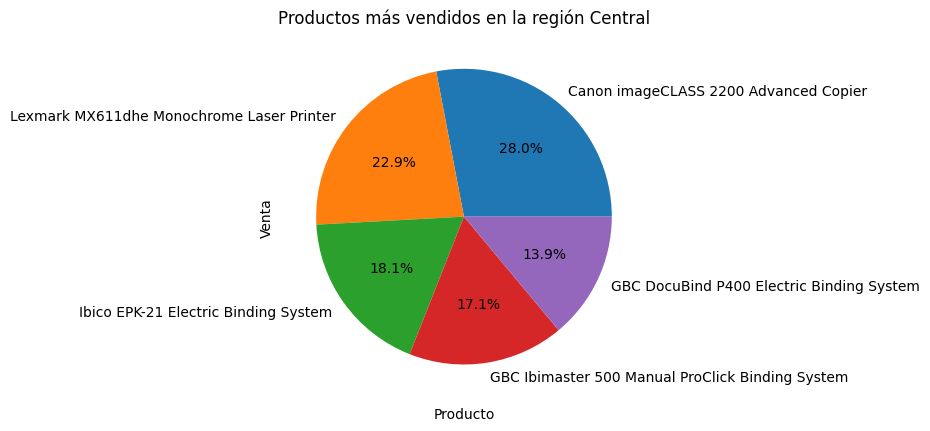

In [111]:
import matplotlib.pyplot as plt

ventas_central = df_merge_dw[df_merge_dw['REGION_NAME'] == 'Central']
ventas_producto = ventas_central.groupby('PRODUCT_NAME')['SALES'].sum()

ventas_producto_top = ventas_producto.nlargest(5)

ventas_producto_top.plot(kind='pie', autopct='%1.1f%%')
plt.title('Productos más vendidos en la región Central')
plt.xlabel('Producto')
plt.ylabel('Venta')
plt.show()

#### 2. ¿Cuales son los productos menos vendidos por en la región SUR?

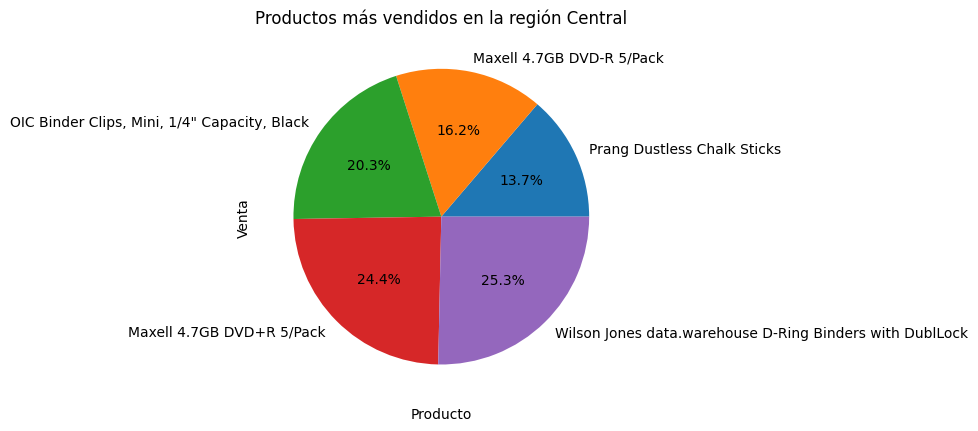

In [112]:
ventas_central = df_merge_dw[df_merge_dw['REGION_NAME'] == 'South']
ventas_producto = ventas_central.groupby('PRODUCT_NAME')['SALES'].sum()

ventas_producto_top = ventas_producto.nsmallest(5)

ventas_producto_top.plot(kind='pie', autopct='%1.1f%%')
plt.title('Productos más vendidos en la región Central')
plt.xlabel('Producto')
plt.ylabel('Venta')
plt.show()

#### 3. ¿Cuáles son los clientes con mayor compra?

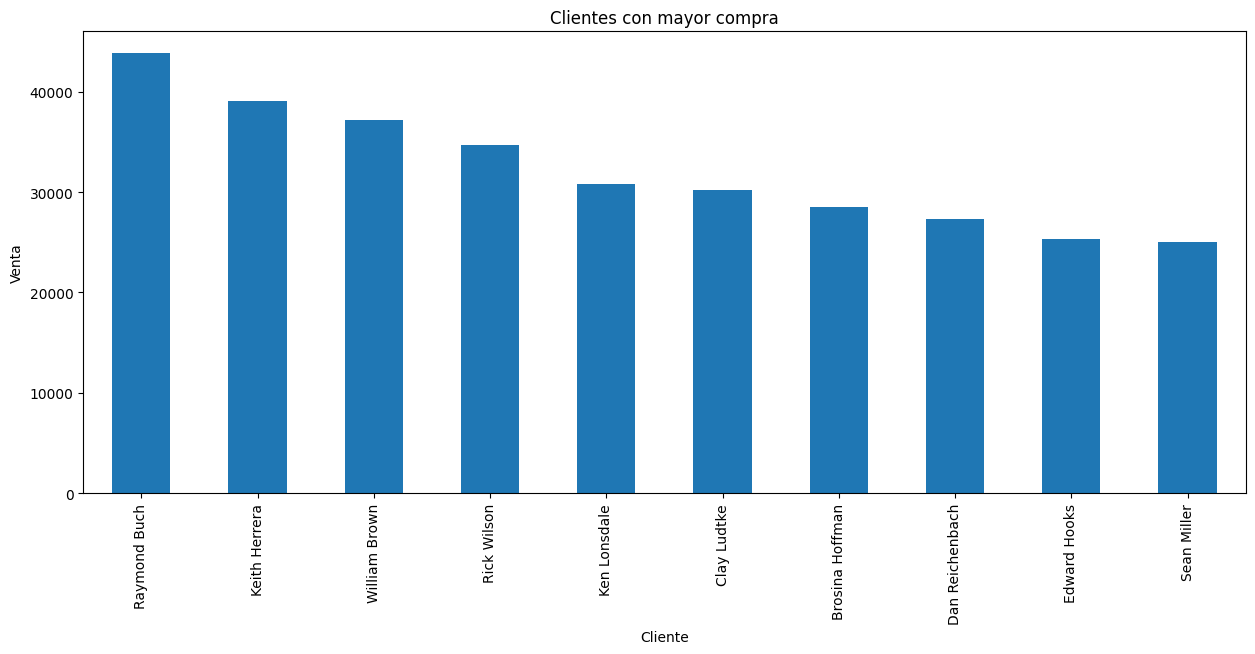

In [113]:
ventas_clientes = df_merge_dw.groupby('CUSTOMER_NAME')['SALES'].sum()

top_clientes = ventas_clientes.nlargest(10)

plt.figure(figsize=(15, 6))
top_clientes.plot(kind='bar')
plt.title('Clientes con mayor compra')
plt.xlabel('Cliente')
plt.ylabel('Venta')
plt.show()

#### 4. ¿Ganancias totales anuales por Región?

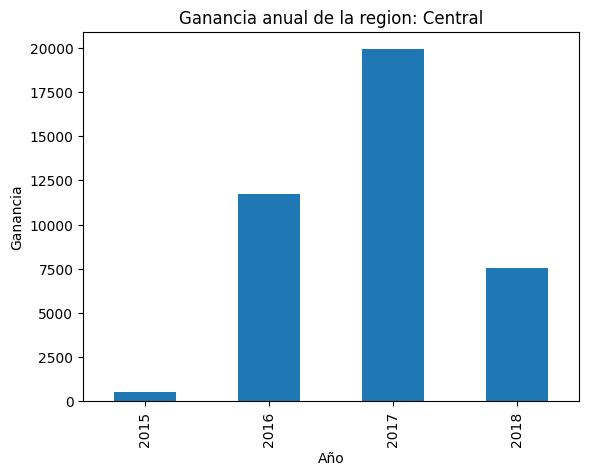

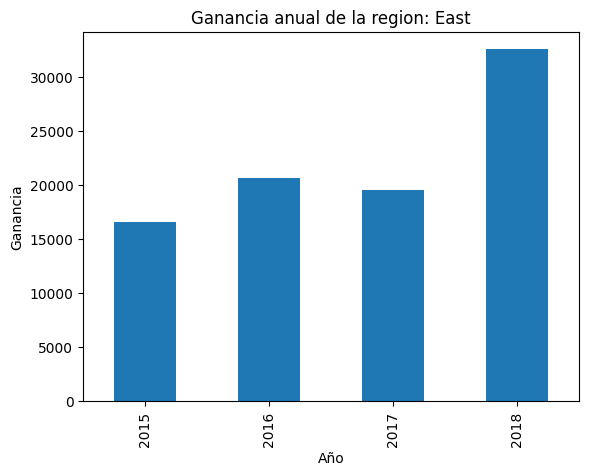

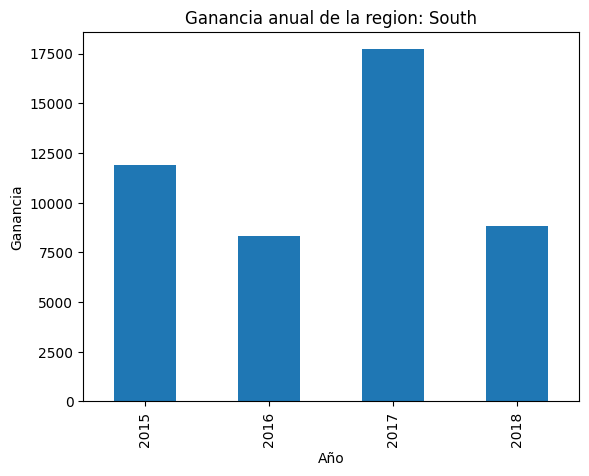

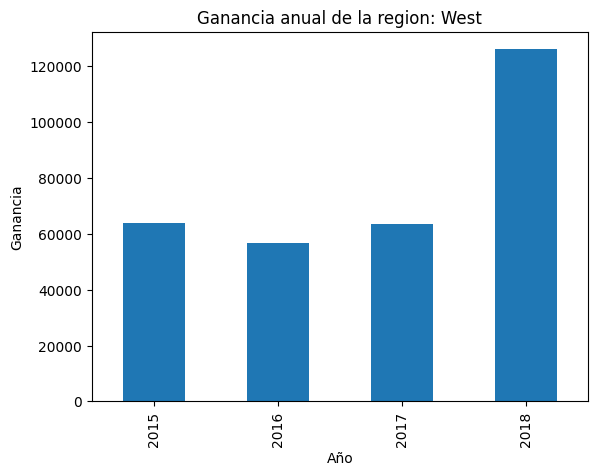

In [133]:

regiones_array = df_merge_dw['REGION_NAME'].unique()

for i in regiones_array:
    ventas_promedio_region = df_merge_dw[df_merge_dw['REGION_NAME'] == i]
    ventas_promedio_per_year = ventas_promedio_region.groupby(['YEAR'])['PROFIT'].sum()
    ventas_promedio_per_year.plot(kind='bar')
    plt.title(f"Ganancia anual de la region: {i}")
    plt.xlabel('Año')
    plt.ylabel('Ganancia')
    plt.show()

#### 5. ¿Ganancia total y descuentos por region?

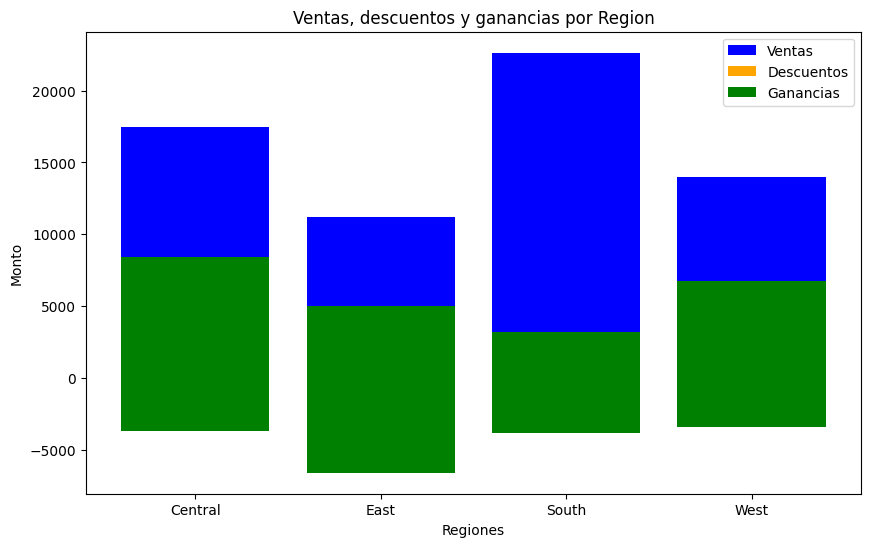

In [138]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(df_merge_dw['REGION_NAME'], df_merge_dw['SALES'], color='blue', label='Ventas')
ax.bar(df_merge_dw['REGION_NAME'], df_merge_dw['DISCOUNT'], color='orange', label='Descuentos')
ax.bar(df_merge_dw['REGION_NAME'], df_merge_dw['PROFIT'], color='green', label='Ganancias')

ax.set_title('Ventas, descuentos y ganancias por Region')
ax.set_xlabel('Regiones')
ax.set_ylabel('Monto')
ax.legend()

plt.show()